# Measuring HII region Photometry

* talked with pascale - discussed measuring photometry of individual HII regions in continuum subtracted image

https://photutils.readthedocs.io/en/stable/segmentation.html

In [74]:
import os
import sys
from photutils import detect_threshold
from photutils import deblend_sources
from photutils import detect_sources
from photutils import source_properties
from photutils import EllipticalAperture
from photutils.psf import IterativelySubtractedPSFPhotometry

from astropy.io import fits
from astropy.table import Table
from astropy.visualization import simple_norm
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy import units as u
import numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook

In [2]:
sys.path.append('/home/rfinn/github/halphagui/')
from photwrapper import ellipse

In [107]:
os.chdir('/home/rfinn/research/Virgo/phot-HIIregion-test/')

In [3]:
help(ellipse)

Help on class ellipse in module photwrapper:

class ellipse(builtins.object)
 |  ellipse(image, image2=None, mask=None, image_frame=None, use_mpl=False, napertures=20, image2_filter=None, filter_ratio=None, psf=None, psf_ha=None)
 |  
 |  class to run photometry routines on image
 |  
 |  INPUT
 |  * image         - primary image (this is usually rband)
 |  * image2        - image2 is designed to be the Halpha image, 
 |                    but it can be any second image whereby you define 
 |                    the ellipse geometry using image 1, and
 |                    measure the photometry on image 1 and image 2
 |  * mask          - mask to apply when measuring photometry.  
 |                    this is usually created from the r-band image
 |  * image_frame   - image frame for plotting inside a gui; like if this is called from halphamain
 |  * use_mpl       - use mpl for testing purposes, before integrating with pyqt gui
 |  * napertures    - number of apertures for measuring p

In [72]:
himage = '/home/rfinn/research/Virgo/gui-output-2017/cutouts/VFID1989-NGC5320/VFID1989-NGC5320-v17p19-CS.fits'
rimage = '/home/rfinn/research/Virgo/gui-output-2017/cutouts/VFID1989-NGC5320/VFID1989-NGC5320-v17p19-R.fits'
mask = '/home/rfinn/research/Virgo/gui-output-2017/cutouts/VFID1989-NGC5320/VFID1989-NGC5320-v17p19-R-mask.fits'
# this is a cutout from pointing 19, 2017
psf= '/home/rfinn/research/Virgo/gui-output-2017/pointing-19_ha4.coadd-psf.fits'

In [73]:
data = fits.getdata(himage)
rdata,rheader = fits.getdata(rimage,header=True)
psf, pheader = fits.getdata(psf,header=True)

# Visualize Image

<IPython.core.display.Javascript object>


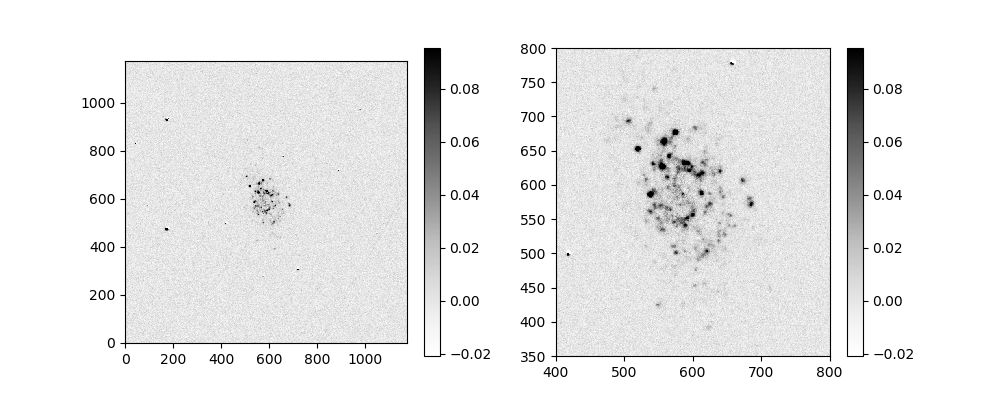

[400, 800, 350, 800]

In [10]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
norm = simple_norm(data, stretch='linear',percent=99.9)
plt.imshow(data, origin='lower',norm=norm,cmap='Greys')
plt.colorbar()
#plt.axis([400,800,350,800])
plt.subplot(1,2,2)
norm = simple_norm(data, stretch='linear',percent=99.9)
plt.imshow(data, origin='lower',norm=norm,cmap='Greys')
plt.colorbar()
plt.axis([400,800,350,800])

# Create instance of ellipse

In [12]:
e = ellipse(rimage,image2=himage,mask=mask)

detect object in rband 

use r-band segementation map to define a mask for halpha

detect sources in halpha, using the r-band mask

# detect object in r-band

In [13]:
e.detect_objects(snrcut=1.5)

<IPython.core.display.Javascript object>


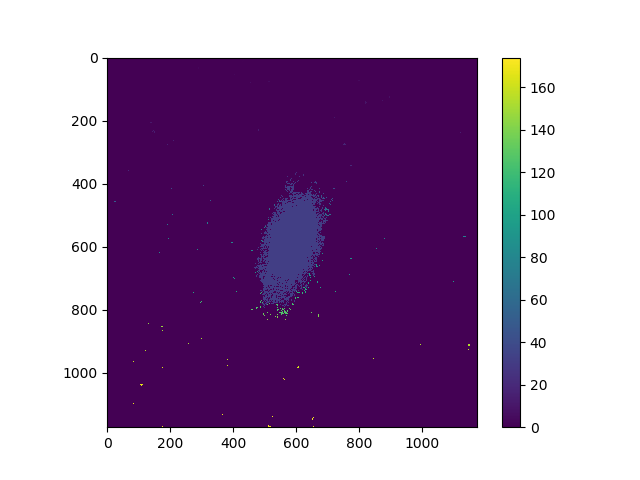

In [14]:
plt.figure()
plt.imshow(e.segmentation.data)
plt.colorbar()

In [15]:
e.find_central_object()

In [16]:
e.objectIndex

31

<IPython.core.display.Javascript object>


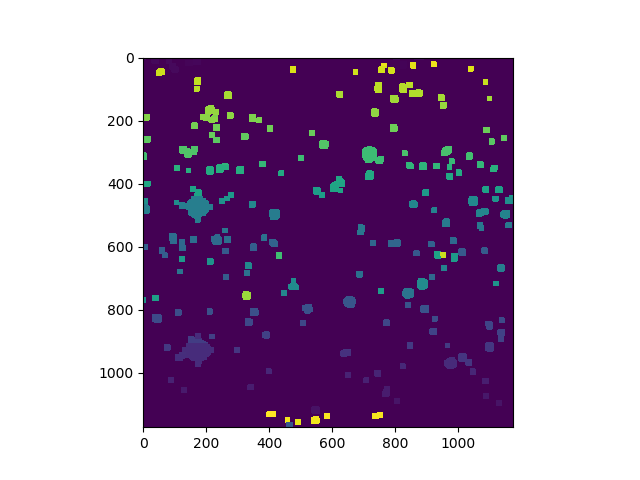

In [20]:
plt.figure()
plt.imshow(e.mask_image)

# Make a mask by flagging everything that is not central object

In [21]:
testmask = e.segmentation.data == e.cat.id[e.objectIndex]

<IPython.core.display.Javascript object>


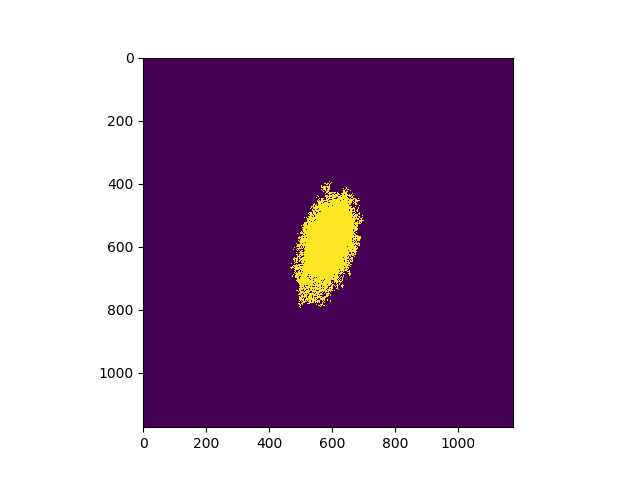

In [22]:
plt.figure()
plt.imshow(testmask)

## invert mask to block everything but pixels associated with central object

In [23]:
invert_testmask = ~testmask

<IPython.core.display.Javascript object>


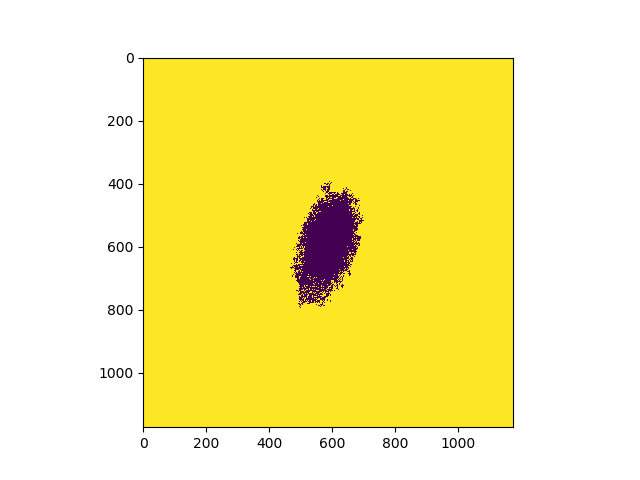

In [25]:
plt.figure()
plt.imshow(invert_testmask)

In [26]:
invert_testmask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [32]:
hthreshold = detect_threshold(e.image2,nsigma=1.5,mask=e.mask_image)

<IPython.core.display.Javascript object>


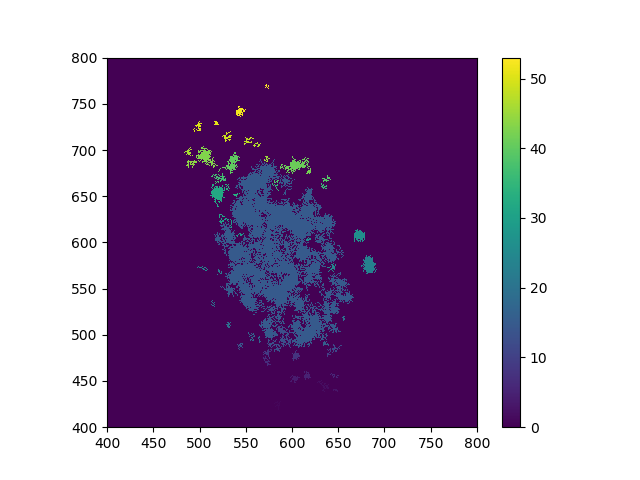

In [47]:
h2seg = detect_sources(e.image2,hthreshold, npixels=10,mask=invert_testmask)
plt.figure()
plt.imshow(h2seg)
plt.axis([400,800,400,800])
plt.colorbar()

<IPython.core.display.Javascript object>


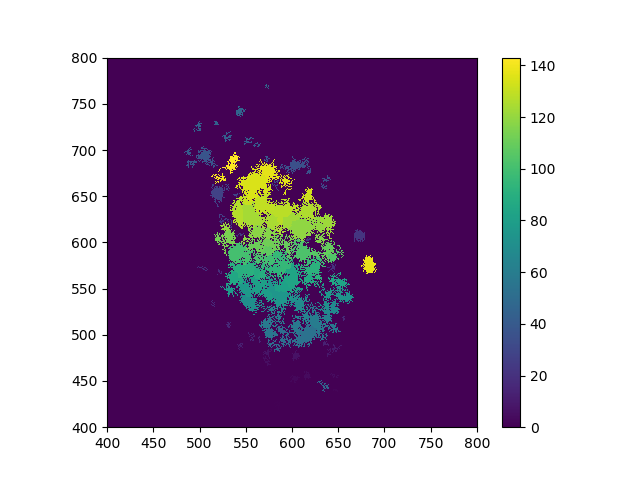

In [46]:
h2seg_deblend = deblend_sources(e.image2,h2seg, npixels=10)
plt.figure()
plt.imshow(h2deblend)
plt.axis([400,800,400,800])
plt.colorbar()

In [48]:
h2cat = source_properties(e.image2,h2seg)
h2cat_deblend = source_properties(e.image2,h2seg_deblend)

In [49]:

tbl_deblend = h2cat_deblend.to_table()

In [51]:
tbl_deblend

id,xcentroid,ycentroid,sky_centroid,sky_centroid_icrs,source_sum,source_sum_err,background_sum,background_mean,background_at_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,min_value,max_value,minval_xpos,minval_ypos,maxval_xpos,maxval_ypos,area,equivalent_radius,perimeter,semimajor_axis_sigma,semiminor_axis_sigma,orientation,eccentricity,ellipticity,elongation,covar_sigx2,covar_sigxy,covar_sigy2,cxx,cxy,cyy,gini
,pix,pix,,,,,,,,pix,pix,pix,pix,,,pix,pix,pix,pix,pix2,pix,pix,pix,pix,deg,,,,pix2,pix2,pix2,1 / pix2,1 / pix2,1 / pix2,
int64,float64,float64,object,object,float32,object,object,object,object,float64,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,585.1609727352567,424.67619889915625,None,None,0.34080446,None,None,None,None,581.0,588.0,419.0,428.0,0.009144636,0.031053435,584.0,424.0,588.0,427.0,24.0,2.763953195770684,18.242640687119284,2.5590361476182633,1.6503565957200537,65.89046734691608,0.7642556904681814,0.35508664179829286,1.55059588591625,3.3619062101144706,1.4261428846591393,5.910436687739136,0.3313684391105232,-0.1599133081379301,0.1884851614420636,0.15339624394107748
2,647.4640296883476,439.7406165730793,None,None,0.21056525,None,None,None,None,645.0,650.0,438.0,441.0,0.009166045,0.028194183,647.0,440.0,647.0,439.0,14.0,2.111004122822376,10.621320343559642,1.5422609003529688,0.868115403689242,-16.117625605633073,0.8265352785628098,0.4371150798865735,1.7765620720457227,2.2533384126953844,-0.4333700492310614,0.8788546261847013,0.4902825335111021,0.48352425840262253,1.2570593963079373,0.1972027510864365
3,602.7667535465171,452.4526631523921,None,None,0.87554544,None,None,None,None,597.0,608.0,448.0,457.0,0.009206094,0.04112768,608.0,454.0,604.0,454.0,49.0,3.949327084834294,37.72792206135786,2.3542170078212257,1.9132008102025357,10.745671519153928,0.5827246107825245,0.18733030818889562,1.230512236492312,5.476912736612082,0.3447454350399615,3.7257623234622814,0.18365427776100451,-0.033987124452335406,0.2699738645882846,0.22389127490868035
4,616.2262314303472,455.8021719690339,None,None,0.696114,None,None,None,None,613.0,620.0,451.0,461.0,0.009516407,0.029763132,616.0,460.0,616.0,457.0,42.0,3.656366395715726,27.763455967290593,2.185198984359851,1.6783327073737602,-64.40340998370917,0.6403950233933698,0.23195428911229166,1.3020058387464966,3.1823195939746562,-0.7630133656857867,4.409575683913203,0.3278375569227167,0.11345510572292586,0.23659507304569008,0.18316369999620202
5,646.1528118691969,455.3564528952234,None,None,0.21193415,None,None,None,None,642.0,650.0,453.0,458.0,0.00923332,0.016655654,648.0,455.0,645.0,455.0,17.0,2.326213245840639,16.863961030678926,2.2801364105837045,1.2185624178949999,-25.06455786187162,0.8452157577673741,0.46557477340443265,1.871169155637112,4.532447002098724,-1.4252798135226272,2.1514694150769254,0.27868780027986195,0.3692435441846248,0.5871046439462327,0.11063825707691873
6,572.9303090635748,470.48010959890314,None,None,0.46286175,None,None,None,None,569.0,577.0,466.0,476.0,0.009314377,0.023396574,570.0,473.0,574.0,468.0,33.0,3.2410224072142872,29.48528137423857,3.104764677079716,1.480870094148809,-56.30091890147327,0.8789212377868807,0.5230330642830916,2.096581387757923,4.485315345973194,-3.4373369177118236,7.347224589813021,0.34756177981299,0.3252076814402164,0.21217864863290287,0.15631185367369357
7,604.1439692741891,476.6894021697742,None,None,0.9431267,None,None,None,None,600.0,608.0,472.0,483.0,0.009168953,0.044238105,600.0,476.0,604.0,476.0,48.0,3.9088200952233594,25.727922061357855,2.1318595087011545,1.740757963389476,63.21025518022729,0.5772826236157522,0.18345559063127892,1.224673132932366,3.33792128547417,0.6093798017749459,4.237141966469234,0.3076656932898277,-0.08849609509125608,0.2423718333181178,0.24380162446302137
8,573.5774896393337,480.41508869381835,None,None,0.6673468,None,None,None,None,569.0,578.0,474.0,484

# Visualize result

In [55]:

r = 3.  # approximate isophotal extent
apertures = []
for obj in h2cat_deblend:
    position = np.transpose((obj.xcentroid.value, obj.ycentroid.value))
    a = obj.semimajor_axis_sigma.value * r
    b = obj.semiminor_axis_sigma.value * r
    theta = obj.orientation.to(u.rad).value
    apertures.append(EllipticalAperture(position, a, b, theta=theta))

<IPython.core.display.Javascript object>


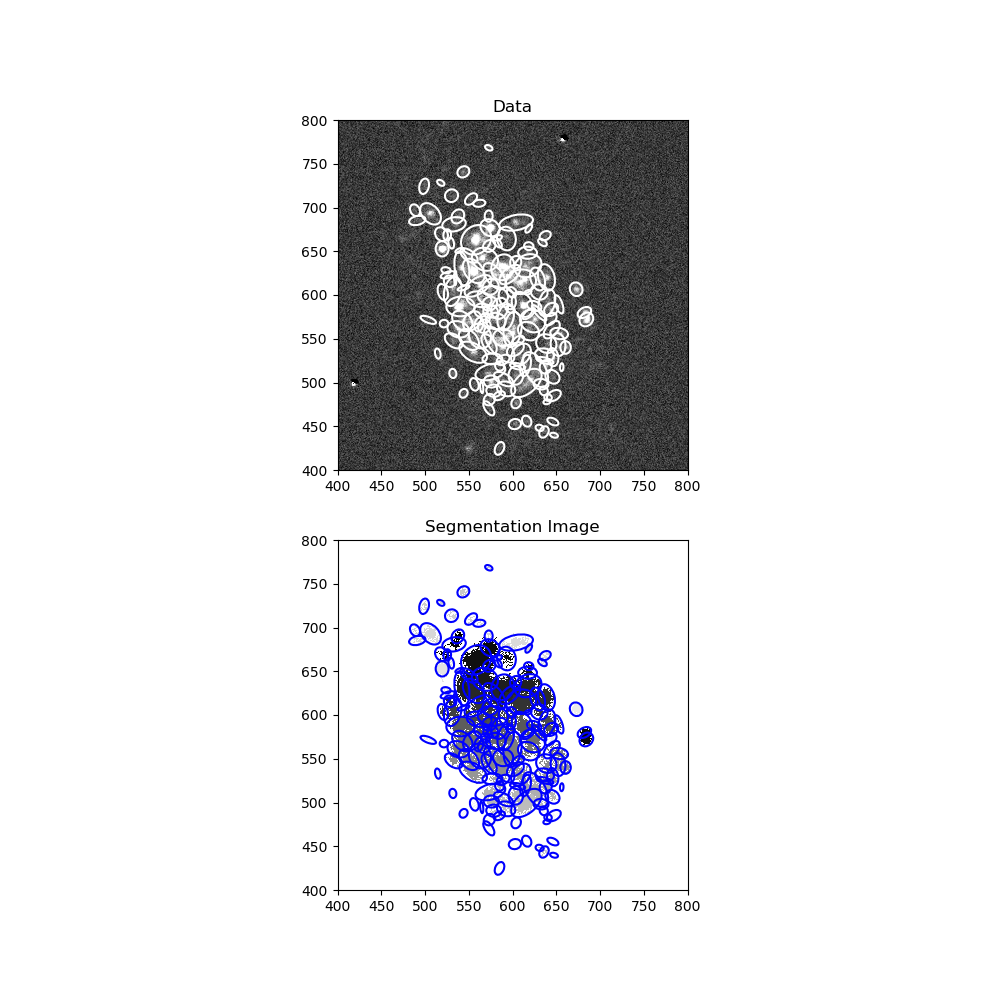

In [69]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
norm = simple_norm(e.image2, stretch='linear',percent=99.9)
ax1.imshow(e.image2, origin='lower', cmap='Greys_r', norm=norm)
ax1.axis([400,800,400,800])
ax1.set_title('Data')
cmap = 'Greys'
ax2.imshow(h2seg_deblend, origin='lower', cmap=cmap,interpolation='nearest')
ax2.axis([400,800,400,800])
ax2.set_title('Segmentation Image')
for aperture in apertures:
    aperture.plot(axes=ax1, color='white', lw=1.5)
    aperture.plot(axes=ax2, color='blue', lw=1.5)

# PSF Photometry

https://photutils.readthedocs.io/en/stable/psf.html#id1


* this is REALLY slow!!!
* it's faster if you provide the positions of the sources, but not everything is a star/point source, so this is probably not the right way to go.

In [91]:
from photutils.detection import IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm
from photutils.psf import IterativelySubtractedPSFPhotometry
from photutils.psf import BasicPSFPhotometry


In [77]:
gaussian_sigma_to_fwhm*2.39

5.628019907623969

In [87]:
bkgrms = MADStdBackgroundRMS()
std = bkgrms(e.image2)

fwhm_psf = pheader['FWHM']
sigma_psf = pheader['STD']
iraffind = IRAFStarFinder(threshold=2.5*std,fwhm=fwhm_psf,
                          minsep_fwhm=0.01, roundhi=5.0, roundlo=-5.0,sharplo=0.0, sharphi=2.0)
daogroup = DAOGroup(2.0*fwhm_psf)
mmm_bkg = MMMBackground()
fitter = LevMarLSQFitter()
psf_model = IntegratedGaussianPRF(sigma=sigma_psf)
#psf_model = psf

photometry = IterativelySubtractedPSFPhotometry(finder=iraffind,group_maker=daogroup,
                                                bkg_estimator=mmm_bkg,psf_model=psf_model,
                                                fitter=LevMarLSQFitter(),niters=3, fitshape=(11,11))
result_tab = photometry(image=e.image2)
residual_image = photometry.get_residual_image()

KeyboardInterrupt: 

In [ ]:
plt.figure()
norm = simple_norm(residual_image,stretch='linear',percent=99.5)
plt.imshow(residual_image, norm=norm,cmap='Grey')

# Fixing centroids

* can use table from detect to fit centroids for psf photometry


In [ ]:
tbl_deblend['xcentroid']

In [89]:
psf_model.x_0.fixed = True
psf_model.y_0.fixed = True
pos = Table(names=['x_0', 'y_0'], data=[tbl_deblend['xcentroid'],tbl_deblend['ycentroid']])

In [93]:
photometry = BasicPSFPhotometry(group_maker=daogroup,
                                bkg_estimator=mmm_bkg,
                                psf_model=psf_model,
                                fitter=LevMarLSQFitter(),
                                fitshape=(11,11))
result_tab = photometry(image=e.image2, init_guesses=pos)
residual_image = photometry.get_residual_image()

<IPython.core.display.Javascript object>


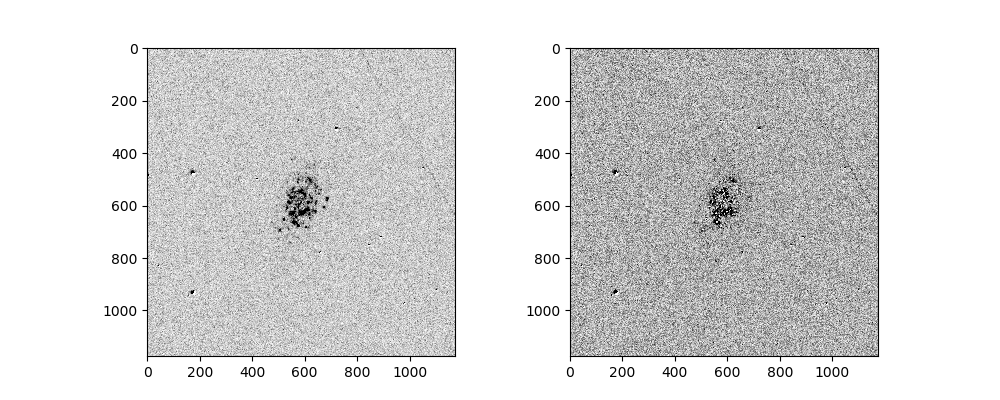

In [98]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
im = e.image2
norm = simple_norm(im,stretch='linear',percent=99.5)
plt.imshow(im, norm=norm,cmap='Greys')

plt.subplot(1,2,2)
im = residual_image
norm = simple_norm(im,stretch='linear',percent=99.5)
plt.imshow(im, norm=norm,cmap='Greys')

# compare photutils and source extractor

* run source extractor on the continuum-subtracted image
* match SE catalog to photutil
  - tbl_deblend
* compare photometry with what we get from photutils detect_sources



In [109]:
!cp ~/github/halphagui/astromatic/default.* .

In [110]:
pwd

'/home/rfinn/research/Virgo/phot-HIIregion-test'

In [111]:
command = 'sex {} -c default.sex.HDI.mask'.format(himage)
print(command)

sex /home/rfinn/research/Virgo/gui-output-2017/cutouts/VFID1989-NGC5320/VFID1989-NGC5320-v17p19-CS.fits -c default.sex.HDI.mask


In [112]:
os.system(command)

0

In [116]:
setab = fits.getdata('test_cat.fits',2)

In [117]:
setab

FITS_rec([(  1,  838.47375  ,   52.964012, 4.725104  , 4.0617175 ,  68.15482   ,  838.73174687,   52.90864764,  1.5744568 ,  1.0849859 ,  835,   47,  839,   54, 207.54527383, 41.30307043, 25.153399, 2.5721996 , 2.77911484e-01,  0.43405622, 24.390234, 1.6961697 ,  2.5527313e-01,  0.44581032, 24.482487, 1.8965960e+00,  2.5527313e-01,  0.44581032, 24.482487, 1.8965960e+00, 7.4623904, 10.56     , 23.955772, 1.4901607e+00, 2.3988903e-02, 4.019527  , 1.5737296e+00, -2.30740532e-01,  0.79851943,  0.49844745,  87.30529  ,  87.31662   , -87.40436   , -87.41569   ,  -2.595642  ,  -2.5843124 , 1.6020132, 0.37578547, 2.7725894 , 1.7305696 ,  3.7215981, 0.00043975,  0, 0, 0, 4.6626854e-01, [25.121801,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ], [2.5383217 , 0.        , 0.        , 0.        , 0.        , 0.        ], [  2.181204  ,   0.        ,   0.        ]),
          (  2,  548.699    , 1121.1238  , 2.711267  , 2.4867883 , -31.129473  ,  548.70014793, 1121.25894013,  1.1563674 ,  0.

In [119]:
tbl_deblend.write('photutil_tbl.tab',format='ipac')